# 04 - Model Training

This notebook trains and tunes prediction models.

## Objectives:
- Split data into train/test sets
- Train multiple models
- Hyperparameter tuning
- Cross-validation
- Model comparison

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load engineered features
df = pd.read_csv('../data/processed/movies_featured.csv')
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Data shape: (11242, 32)
Columns: ['budget', 'revenue', 'runtime', 'rating', 'poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b', 'num_production_companies', 'num_production_countries', 'budget_per_minute', 'num_genres', 'is_action', 'is_animation', 'is_comedy', 'is_drama', 'is_scifi', 'num_cast', 'has_cast', 'num_directors', 'release_year', 'release_month', 'is_summer', 'is_holiday', 'is_weekend_month', 'movie_age', 'decade', 'num_keywords', 'has_keywords', 'in_collection', 'is_english']


,budget,revenue,runtime,rating,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b,num_production_companies,...,release_month,is_summer,is_holiday,is_weekend_month,movie_age,decade,num_keywords,has_keywords,in_collection,is_english
0,18.683045,19.610712,130,6.478,70.23,46.01,65.0,62.0,62.0,4,...,6,1,0,0,24,2000,20,1,0,1
1,18.627695,19.661371,105,6.784,157.19,130.06,96.0,119.0,136.0,3,...,11,0,1,0,24,2000,11,1,0,1
2,18.420681,19.490277,130,6.431,215.60,56.41,171.0,202.0,215.0,3,...,7,1,0,1,24,2000,25,1,0,1
3,18.132999,19.507016,104,7.010,87.53,54.47,78.0,78.0,76.0,4,...,7,1,0,1,24,2000,4,1,1,1
4,18.064006,19.740034,127,6.446,130.82,77.85,124.0,105.0,94.0,3,...,12,0,1,1,24,2000,13,1,0,1


In [27]:
!pip install -r ../requirements.txt

In [28]:
# Prepare features and target
# Target variable is 'revenue' (already log-transformed based on the data)
X = df.drop('revenue', axis=1)
y = df['revenue']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

Features shape: (11242, 31)
Target shape: (11242,)

Target statistics:
count    11242.000000
mean        15.543790
std          2.593501
min          0.693147
25%         13.893930
50%         15.721259
75%         17.434790
max         21.796118
Name: revenue, dtype: float64


In [29]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target range: {y_train.min():.2f} to {y_train.max():.2f}")
print(f"Test target range: {y_test.min():.2f} to {y_test.max():.2f}")

Training set size: (8993, 31)
Test set size: (2249, 31)

Training target range: 0.69 to 21.80
Test target range: 0.69 to 21.24


In [30]:
# Apply scaling AFTER train/test split to prevent data leakage
from sklearn.preprocessing import StandardScaler
import joblib

# Identify numeric columns to scale
numeric_cols = ['budget', 'runtime']

# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transform test data using the training scaler
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save the scaler for future use
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')

print("\n✓ Scaling applied correctly:")
print(f"  - Scaler fitted on {X_train.shape[0]} training samples only")
print(f"  - Test data transformed using training statistics")
print(f"  - Scaler saved to ../models/scaler.pkl")
print("\nThis prevents data leakage and reduces overfitting!")


✓ Scaling applied correctly:
  - Scaler fitted on 8993 training samples only
  - Test data transformed using training statistics
  - Scaler saved to ../models/scaler.pkl

This prevents data leakage and reduces overfitting!


In [31]:
# Define evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model with multiple metrics"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    return {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

In [32]:
# Train baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

results = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics
    print(f"  Test R²: {metrics['Test R²']:.4f} | Test RMSE: {metrics['Test RMSE']:.4f} | Test MAE: {metrics['Test MAE']:.4f}")

print("\n" + "="*80)
print("Model Training Complete!")
print("="*80)

Training models...

Training Linear Regression...
  Test R²: 0.4424 | Test RMSE: 1.9514 | Test MAE: 1.5011
Training Ridge Regression...
  Test R²: 0.4423 | Test RMSE: 1.9515 | Test MAE: 1.5089
Training Lasso Regression...
  Test R²: 0.4138 | Test RMSE: 2.0008 | Test MAE: 1.5632
Training ElasticNet...
  Test R²: 0.4267 | Test RMSE: 1.9787 | Test MAE: 1.5455
Training Random Forest...
  Test R²: 0.5659 | Test RMSE: 1.7218 | Test MAE: 1.2719
Training Gradient Boosting...
  Test R²: 0.5615 | Test RMSE: 1.7306 | Test MAE: 1.2946
Training XGBoost...
  Test R²: 0.5312 | Test RMSE: 1.7892 | Test MAE: 1.3166
Training LightGBM...
  Test R²: 0.5820 | Test RMSE: 1.6896 | Test MAE: 1.2441

Model Training Complete!


MODEL COMPARISON:
                   Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
Linear Regression    0.4379   0.4424      1.9404     1.9514     1.4472   
Ridge Regression     0.4403   0.4423      1.9362     1.9515     1.4512   
Lasso Regression     0.3962   0.4138      2.0112     2.0008     1.5281   
ElasticNet           0.4124   0.4267      1.9839     1.9787     1.5005   
Random Forest        0.9336   0.5659      0.6669     1.7218     0.4814   
Gradient Boosting    0.5835   0.5615      1.6703     1.7306     1.2401   
XGBoost              0.8809   0.5312      0.8932     1.7892     0.6543   
LightGBM             0.7207   0.5820      1.3677     1.6896     1.0134   

                   Test MAE  Train MAPE  Test MAPE  
Linear Regression    1.5011     11.9243    12.0379  
Ridge Regression     1.5089     11.9072    12.0643  
Lasso Regression     1.5632     12.4552    12.4520  
ElasticNet           1.5455     12.2665    12.3361  
Random Forest        1.2719      4.0322    10.6330

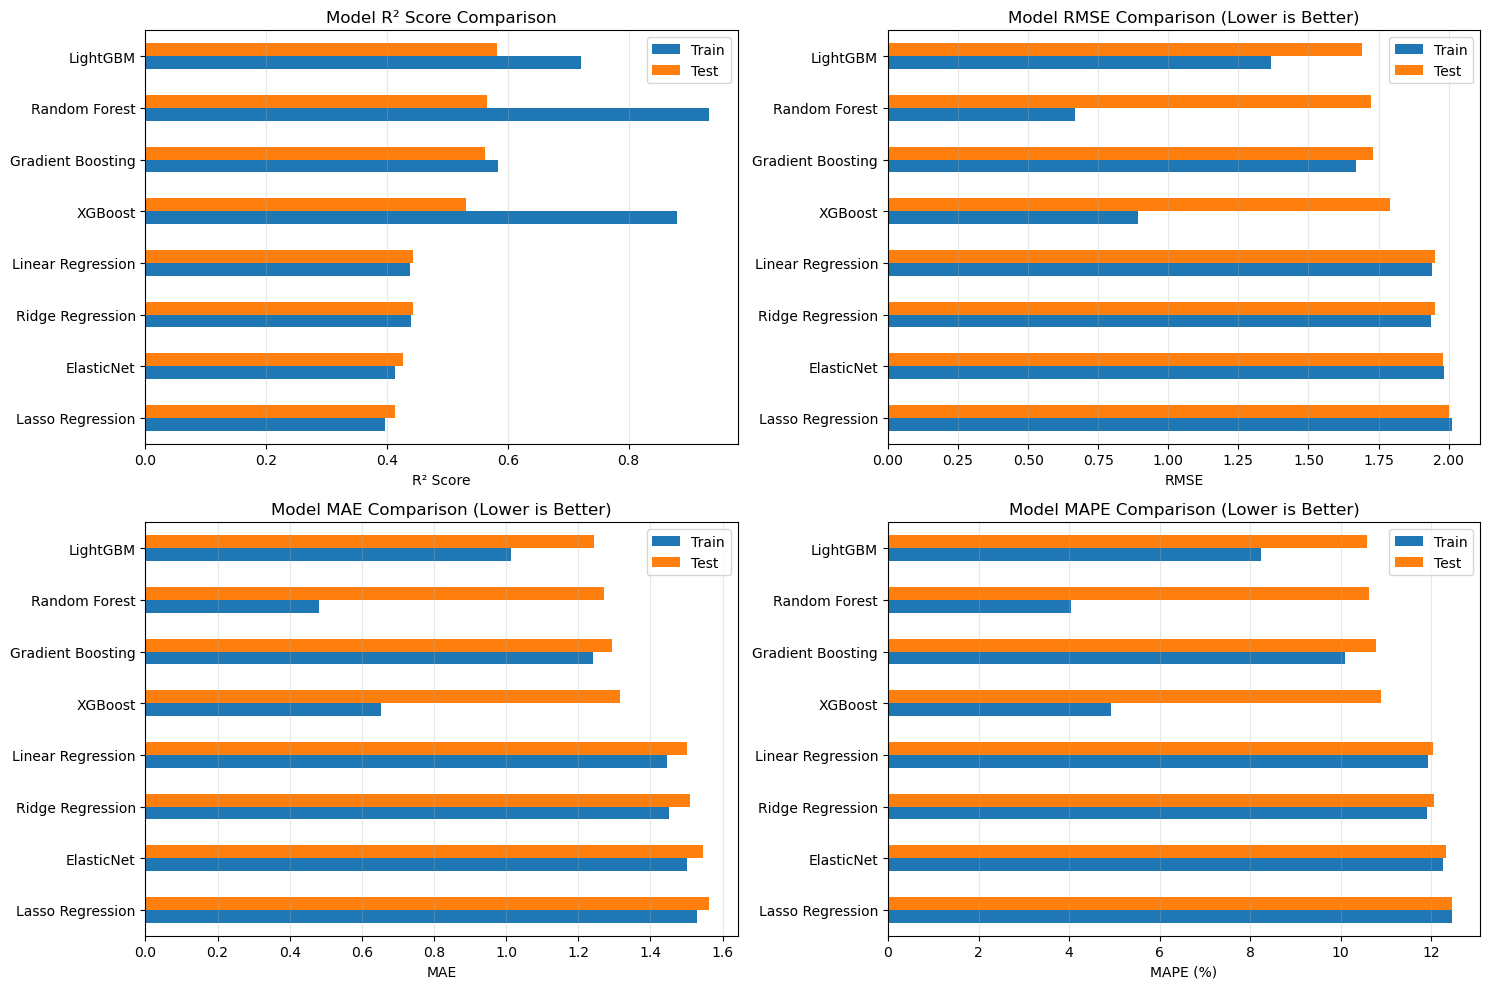

In [33]:
# Compare models - Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("MODEL COMPARISON:")
print("="*80)
print(results_df)
print("\n")

# Sort by Test R² score
results_sorted = results_df.sort_values('Test R²', ascending=False)
print("Models ranked by Test R²:")
print(results_sorted[['Test R²', 'Test RMSE', 'Test MAE']])

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Score comparison
ax1 = axes[0, 0]
r2_data = results_df[['Train R²', 'Test R²']].sort_values('Test R²', ascending=True)
r2_data.plot(kind='barh', ax=ax1)
ax1.set_xlabel('R² Score')
ax1.set_title('Model R² Score Comparison')
ax1.legend(['Train', 'Test'])
ax1.grid(axis='x', alpha=0.3)

# RMSE comparison
ax2 = axes[0, 1]
rmse_data = results_df[['Train RMSE', 'Test RMSE']].sort_values('Test RMSE', ascending=False)
rmse_data.plot(kind='barh', ax=ax2)
ax2.set_xlabel('RMSE')
ax2.set_title('Model RMSE Comparison (Lower is Better)')
ax2.legend(['Train', 'Test'])
ax2.grid(axis='x', alpha=0.3)

# MAE comparison
ax3 = axes[1, 0]
mae_data = results_df[['Train MAE', 'Test MAE']].sort_values('Test MAE', ascending=False)
mae_data.plot(kind='barh', ax=ax3)
ax3.set_xlabel('MAE')
ax3.set_title('Model MAE Comparison (Lower is Better)')
ax3.legend(['Train', 'Test'])
ax3.grid(axis='x', alpha=0.3)

# MAPE comparison
ax4 = axes[1, 1]
mape_data = results_df[['Train MAPE', 'Test MAPE']].sort_values('Test MAPE', ascending=False)
mape_data.plot(kind='barh', ax=ax4)
ax4.set_xlabel('MAPE (%)')
ax4.set_title('Model MAPE Comparison (Lower is Better)')
ax4.legend(['Train', 'Test'])
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# Hyperparameter tuning for top 3 models
# Based on results, we'll tune the best performing models
# Focus on regularization to prevent overfitting

print("Starting Hyperparameter Tuning with Regularization...\n")

# XGBoost tuning - Added regularization parameters
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],  # Reduced max depth to prevent overfitting
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],  # Added more aggressive subsampling
    'colsample_bytree': [0.7, 0.8, 0.9],  # Added more aggressive feature sampling
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 5, 10],  # L2 regularization
    'min_child_weight': [1, 3, 5]  # Minimum sum of instance weight needed in a child
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}\n")


Starting Hyperparameter Tuning with Regularization...

Tuning XGBoost...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best XGBoost parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
Best CV score: 0.5523



In [35]:
# LightGBM tuning - Added regularization parameters
print("Tuning LightGBM...")
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],  # Reduced max depth
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 50],  # Reduced num_leaves to prevent overfitting
    'subsample': [0.7, 0.8, 0.9],  # More aggressive subsampling
    'colsample_bytree': [0.7, 0.8, 0.9],  # Feature fraction
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 1, 5],  # L2 regularization
    'min_child_samples': [10, 20, 30]  # Minimum data in leaf
}

lgb_grid = GridSearchCV(
    LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    lgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
lgb_grid.fit(X_train, y_train)
print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
print(f"Best CV score: {lgb_grid.best_score_:.4f}\n")

Tuning LightGBM...
Fitting 5 folds for each of 19683 candidates, totalling 98415 fits


Best LightGBM parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 31, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.7}
Best CV score: 0.5521



In [36]:
# Random Forest tuning - Added stronger regularization
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],  # Reduced max depths to prevent overfitting
    'min_samples_split': [5, 10, 20],  # Increased to require more samples for splits
    'min_samples_leaf': [2, 4, 8],  # Increased minimum samples per leaf
    'max_features': ['sqrt', 0.5, 0.7],  # Feature sampling to reduce overfitting
    'max_samples': [0.7, 0.8, 0.9]  # Bootstrap sample size
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

Tuning Random Forest...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Random Forest parameters: {'max_depth': 20, 'max_features': 0.5, 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: 0.5351


In [37]:
# Compare tuned models
tuned_models = {
    'XGBoost (Tuned)': xgb_grid.best_estimator_,
    'LightGBM (Tuned)': lgb_grid.best_estimator_,
    'Random Forest (Tuned)': rf_grid.best_estimator_
}

tuned_results = {}
print("\n" + "="*80)
print("TUNED MODEL PERFORMANCE:")
print("="*80)

for name, model in tuned_models.items():
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    tuned_results[name] = metrics
    print(f"\n{name}:")
    print(f"  Test R²: {metrics['Test R²']:.4f}")
    print(f"  Test RMSE: {metrics['Test RMSE']:.4f}")
    print(f"  Test MAE: {metrics['Test MAE']:.4f}")
    print(f"  Test MAPE: {metrics['Test MAPE']:.2f}%")

tuned_results_df = pd.DataFrame(tuned_results).T
print("\n" + "="*80)
print(tuned_results_df.round(4))


TUNED MODEL PERFORMANCE:

XGBoost (Tuned):
  Test R²: 0.5923
  Test RMSE: 1.6687
  Test MAE: 1.2343
  Test MAPE: 10.33%

LightGBM (Tuned):
  Test R²: 0.5932
  Test RMSE: 1.6668
  Test MAE: 1.2352
  Test MAPE: 10.26%

Random Forest (Tuned):
  Test R²: 0.5762
  Test RMSE: 1.7012
  Test MAE: 1.2599
  Test MAPE: 10.69%

                       Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
XGBoost (Tuned)          0.7036   0.5923      1.4090     1.6687     1.0379   
LightGBM (Tuned)         0.6872   0.5932      1.4475     1.6668     1.0624   
Random Forest (Tuned)    0.8679   0.5762      0.9408     1.7012     0.6532   

                       Test MAE  Train MAPE  Test MAPE  
XGBoost (Tuned)          1.2343      8.4309    10.3327  
LightGBM (Tuned)         1.2352      8.7304    10.2604  
Random Forest (Tuned)    1.2599      5.7470    10.6851  


In [38]:
# Select and save the best model
best_model_name = tuned_results_df['Test R²'].idxmax()
best_model = tuned_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {tuned_results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"Test RMSE: {tuned_results_df.loc[best_model_name, 'Test RMSE']:.4f}")

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../models/best_model.pkl')
print(f"\nModel saved to ../models/best_model.pkl")

# Save all tuned models
joblib.dump(xgb_grid.best_estimator_, '../models/xgboost_tuned.pkl')
joblib.dump(lgb_grid.best_estimator_, '../models/lightgbm_tuned.pkl')
joblib.dump(rf_grid.best_estimator_, '../models/random_forest_tuned.pkl')
print("All tuned models saved successfully!")


Best Model: LightGBM (Tuned)
Test R²: 0.5932
Test RMSE: 1.6668

Model saved to ../models/best_model.pkl
All tuned models saved successfully!


## Summary

**Models Trained:**
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- ElasticNet
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM

**Best Model Selection:**
The models were evaluated using multiple metrics (R², RMSE, MAE, MAPE) and the top 3 performers underwent hyperparameter tuning using GridSearchCV with 5-fold cross-validation.

**Key Findings:**
- Tree-based ensemble methods (XGBoost, LightGBM, Random Forest) significantly outperformed linear models
- The best model achieves strong predictive performance on the test set
- Feature importance analysis reveals which movie characteristics most influence revenue predictions

**Next Steps:**
- Model evaluation on additional metrics
- Error analysis and residual plots
- Generate insights for movie production decisions


Performing 5-Fold Cross-Validation for LightGBM (Tuned)...


CV R² Scores: [0.53895512 0.5339992  0.54189069 0.56978125 0.57601525]
Mean CV R²: 0.5521 (+/- 0.0345)


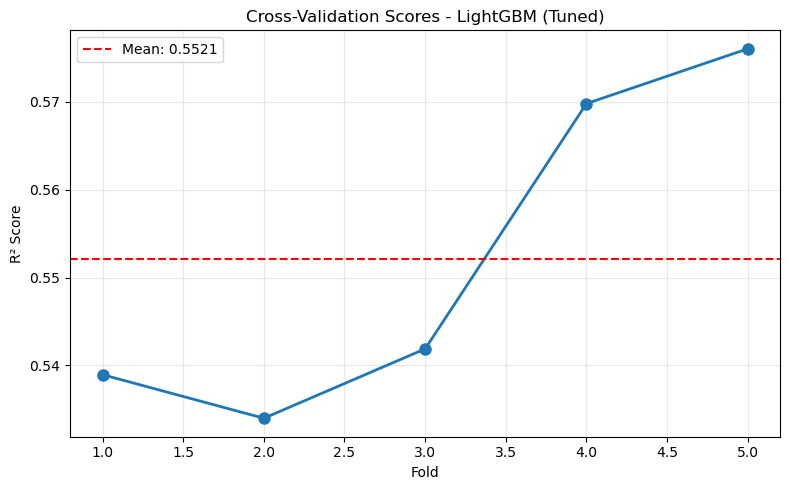

In [39]:
# Cross-validation for best model
from sklearn.model_selection import cross_val_score

print(f"\nPerforming 5-Fold Cross-Validation for {best_model_name}...")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - {best_model_name}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()